#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.


### CHAPTER 20
**CH20A Working from home and employee performance**

using the wfh dataset

version 0.9 2020-09-11

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import sys
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"

# location folders
data_in = dirname + "da_data_repo/working-from-home/clean/"
data_out = dirname + "da_case_studies/ch20-working-from-home/"
output = dirname + "da_case_studies/ch20-working-from-home/output/"

func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions 
from py_helper_functions import *

### Load data

In [34]:
# !!! note: only .dta file in data_repo, no csv
data = pd.read_stata(data_in + "wfh_tidy_person.dta")

In [6]:
data = pd.concat(
    [
        data.loc[:, "personid":"perform11"],
        data.loc[
            :,
            [
                "age",
                "male",
                "second_technical",
                "high_school",
                "tertiary_technical",
                "university",
                "prior_experience",
                "tenure",
                "married",
                "children",
                "ageyoungestchild",
                "rental",
                "costofcommute",
                "internet",
                "bedroom",
                "basewage",
                "bonus",
                "grosswage",
            ],
        ],
    ],
    axis=1,
)

### Balance

In [7]:
data["ageyoungestchild"] = np.where(
    data["children"] == 0, None, data["ageyoungestchild"]
)

In [8]:
# convertin nonnumeric dummies to numeric
data["children"] = np.where(data["children"] == "yes", 1, 0)
data["rental"] = np.where(data["rental"] == "yes", 1, 0)
data["bedroom"] = np.where(data["bedroom"] == "yes", 1, 0)
data["ageyoungestchild"] = pd.to_numeric(data["ageyoungestchild"])

In [9]:
variables = pd.concat(
    [data["perform10"], data.loc[:, "age":"grosswage"], data["ordertaker"]], axis=1
).columns.tolist()

In [10]:
mean_t = dict()
mean_c = dict()
sd = dict()
p_value = dict()

In [11]:
for i in variables:
    # Regression model
    model = smf.ols(formula="{i}~treatment".format(i=i), data=data).fit()

    # Mean control
    mean_c[i] = data.loc[data["treatment"] == 0, i].dropna().mean()
    # Mean treated
    mean_t[i] = data.loc[data["treatment"] == 1, i].dropna().mean()
    # p-value from regression
    p_value[i] = model.pvalues[1]
    # Standard deviation
    sd[i] = data[i].dropna().std()

In [12]:
table = pd.DataFrame([mean_t, mean_c, sd, p_value]).T.round(2)
table.columns = [
    "Treatment mean",
    "Control mean",
    "Std.dev.",
    "p-value of test of equal means",
]

In [13]:
table

,Treatment mean,Control mean,Std.dev.,p-value of test of equal means
perform10,-0.03,-0.04,0.58,0.87
age,24.44,24.35,3.55,0.85
male,0.47,0.47,0.50,0.99
second_technical,0.46,0.47,0.50,0.79
high_school,0.18,0.14,0.36,0.39
tertiary_technical,0.35,0.36,0.48,0.94
university,0.02,0.03,0.15,0.34
prior_experience,18.96,16.75,25.88,0.50
tenure,26.14,28.25,21.92,0.45
married,0.22,0.32,0.44,0.07


 ### outcomes

In [14]:
# quit firm during 8 months of experiment
# phone calls worked, for order takers

In [15]:
quitjobs = (
    data.groupby("treatment")
    .agg(mean=("quitjob", "mean"), std=("quitjob", "std"), N=("quitjob", "count"))
    .round(3)
)

In [16]:
total_quitjob = data.agg(
    mean_total=("quitjob", "mean"),
    std_total=("quitjob", "std"),
    N_total=("quitjob", "count"),
).T.round(3)

In [17]:
quitjobs

,mean,std,N
treatment,,,
0,0.347,0.478,118
1,0.160,0.368,131


In [18]:
total_quitjob

,mean_total,std_total,N_total
quitjob,0.249,0.433,249.0


In [19]:
phonecalls1 = data.query("ordertaker==1").groupby("treatment").agg(
    mean=("phonecalls1", "mean"), std=("phonecalls1", "std"), N=("phonecalls1", "count")
).round(2)

In [20]:
total_phonecalls = (
    data.query("ordertaker==1")
    .agg(
        mean_total=("phonecalls1", "mean"),
        std_total=("phonecalls1", "std"),
        N_total=("phonecalls1", "count"),
    )
    .T.round(2)
)

In [21]:
phonecalls1

,mean,std,N
treatment,,,
0,10.06,6.10,66
1,14.10,5.31,68


In [22]:
total_phonecalls

,mean_total,std_total,N_total
phonecalls1,12.11,6.04,134.0


In [23]:
# Bar chart for quit rates

In [24]:
data["quit_pct"] = data["quitjob"] * 100
data["stayed_pct"] = (1 - data["quitjob"]) * 100

In [25]:
barchart_data = pd.melt(
    data[["treatment", "quit_pct", "stayed_pct"]]
    .groupby("treatment")
    .agg({"quit_pct": "mean", "stayed_pct": "mean"})
    .reset_index(),
    id_vars="treatment",
).rename(columns={"variable": "employees", "value": "pct"})

In [26]:
barchart_data["treatment"] = np.where(
    barchart_data["treatment"] == 0, "Non-treatment group", "Treatment group"
)

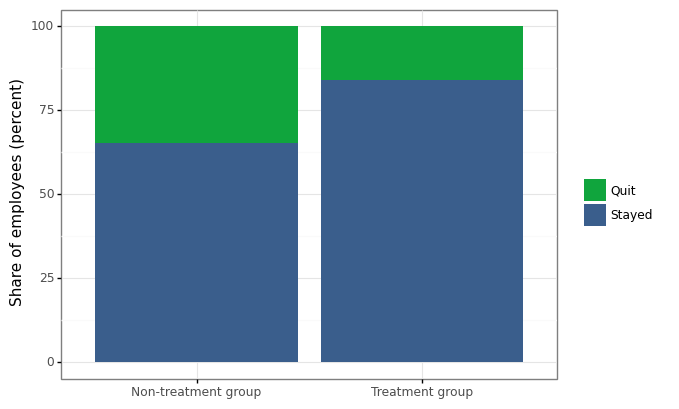

<ggplot: (310442394)>

In [27]:
quitrates_barchart = (
    ggplot(barchart_data, aes(fill="employees", y="pct", x="treatment"))
    + geom_bar(stat="identity")
    + theme_bw()
    + labs(y="Share of employees (percent)", x="")
    + scale_x_discrete()
    + scale_fill_manual(
        labels=("Quit", "Stayed"), name=" ", values=(color[1], color[0])
    )
)

quitrates_barchart

### Regression analysis 
 Outcome variables: 1) quit firm during 8 months of experiment , 2) phone calls worked, for ordertakers

In [28]:
# Outcomes by treatment

# 1) Quit firm
quitjobs

,mean,std,N
treatment,,,
0,0.347,0.478,118
1,0.160,0.368,131


In [29]:
# 2) Phonecalls (ordertakers only)
phonecalls1

,mean,std,N
treatment,,,
0,10.06,6.10,66
1,14.10,5.31,68


### Regression 1: ATE estimates, no covariates

In [30]:
reg1 = smf.ols(formula="quitjob~treatment", data=data).fit(cov_type="HC1")
reg2 = smf.ols(formula="phonecalls1~treatment", data=data.query("ordertaker==1")).fit(cov_type="HC1")

In [31]:
stargazer = Stargazer([reg1, reg2])
stargazer.rename_covariates({"Intercept": "Constant"})
HTML(stargazer.render_html())

### Regression 2: ATE estimates, with covariates of some unbalance

In [32]:
reg3 = smf.ols(
    formula="quitjob ~ treatment + married + children + internet", data=data
).fit(cov_type="HC1")
reg4 = smf.ols(
    formula="phonecalls1 ~ treatment + married + children + internet",
    data=data.query("ordertaker==1"),
).fit(cov_type="HC1")

In [33]:
stargazer = Stargazer([reg3, reg4])
stargazer.rename_covariates({"Intercept": "Constant"})
HTML(stargazer.render_html())